In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 23.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 22.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [4]:
#@train_df = pd.read_csv("files/test_correlation_above_glcm.csv")
#train_df2 = pd.read_csv("files/test_correlation_below_glcm.csv")

train_df = pd.read_csv("files/mit_indoor/lbp/mit_lbp_above.csv")
train_df2 = pd.read_csv("files/mit_indoor/lbp/mit_lbp_below.csv")

In [5]:
print(train_df2)

                                       file          label
0     airportinside/airport_inside_0102.jpg  airportinside
1     airportinside/airport_inside_0076.jpg  airportinside
2     airportinside/airport_inside_0174.jpg  airportinside
3     airportinside/airport_inside_0215.jpg  airportinside
4     airportinside/airport_inside_0236.jpg  airportinside
...                                     ...            ...
2632                 cloister/claustro2.jpg       cloister
2633         cloister/claustro_romanico.jpg       cloister
2634       cloister/96847179_5961f50b85.jpg       cloister
2635    cloister/cloister_cc_redandgray.jpg       cloister
2636                 cloister/cloister5.jpg       cloister

[2637 rows x 2 columns]


In [6]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [7]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df,
                                                         directory="mit_indoor_67",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df2,
                                                         directory="mit_indoor_67",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 1520 non-validated image filenames belonging to 15 classes.
Found 2110 non-validated image filenames belonging to 15 classes.


In [8]:
model_name = vgg16
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

In [9]:
model_t.trainable = False
model_t2.trainable = False

In [10]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [11]:
#model classifier topup
#reg=0.001

model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(15, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(15, activation='softmax'))

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [13]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=150, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=150, verbose=1)


Epoch 1/150
190/190 [==============================] - 73s 364ms/step - loss: 2.9052 - accuracy: 0.1656 - precision: 0.3069 - recall: 0.0507
Epoch 2/150
190/190 [==============================] - 33s 175ms/step - loss: 2.0246 - accuracy: 0.3485 - precision: 0.5872 - recall: 0.1544
Epoch 3/150
190/190 [==============================] - 33s 172ms/step - loss: 1.8230 - accuracy: 0.4416 - precision: 0.6756 - recall: 0.2145
Epoch 4/150
190/190 [==============================] - 33s 171ms/step - loss: 1.6531 - accuracy: 0.4858 - precision: 0.7637 - recall: 0.2597
Epoch 5/150
190/190 [==============================] - 33s 173ms/step - loss: 1.5961 - accuracy: 0.5314 - precision: 0.7366 - recall: 0.2622
Epoch 6/150
190/190 [==============================] - 33s 174ms/step - loss: 1.5575 - accuracy: 0.5228 - precision: 0.7553 - recall: 0.2967
Epoch 7/150
190/190 [==============================] - 33s 173ms/step - loss: 1.5106 - accuracy: 0.5592 - precision: 0.7499 - recall: 0.2975
Epoch 8/150
1

190/190 [==============================] - 33s 171ms/step - loss: 1.0733 - accuracy: 0.6659 - precision: 0.8369 - recall: 0.4608
Epoch 62/150
190/190 [==============================] - 34s 177ms/step - loss: 1.0287 - accuracy: 0.6885 - precision: 0.8239 - recall: 0.4778
Epoch 63/150
190/190 [==============================] - 34s 178ms/step - loss: 1.0468 - accuracy: 0.6749 - precision: 0.8290 - recall: 0.4932
Epoch 64/150
190/190 [==============================] - 34s 178ms/step - loss: 0.9534 - accuracy: 0.6978 - precision: 0.8413 - recall: 0.5111
Epoch 65/150
190/190 [==============================] - 33s 174ms/step - loss: 1.0077 - accuracy: 0.6946 - precision: 0.8277 - recall: 0.5063
Epoch 66/150
190/190 [==============================] - 33s 174ms/step - loss: 0.9276 - accuracy: 0.7239 - precision: 0.8715 - recall: 0.5257
Epoch 67/150
190/190 [==============================] - 33s 173ms/step - loss: 0.9479 - accuracy: 0.7142 - precision: 0.8694 - recall: 0.5142
Epoch 68/150
190/19

190/190 [==============================] - 33s 173ms/step - loss: 1.1562 - accuracy: 0.6340 - precision: 0.8144 - recall: 0.4006
Epoch 121/150
190/190 [==============================] - 33s 171ms/step - loss: 1.0921 - accuracy: 0.6652 - precision: 0.8398 - recall: 0.4378
Epoch 122/150
190/190 [==============================] - 33s 171ms/step - loss: 1.1980 - accuracy: 0.6152 - precision: 0.8187 - recall: 0.3999
Epoch 123/150
190/190 [==============================] - 33s 172ms/step - loss: 1.1440 - accuracy: 0.6296 - precision: 0.8133 - recall: 0.3988
Epoch 124/150
190/190 [==============================] - 33s 173ms/step - loss: 1.1146 - accuracy: 0.6331 - precision: 0.8415 - recall: 0.4243
Epoch 125/150
190/190 [==============================] - 33s 173ms/step - loss: 1.1043 - accuracy: 0.6546 - precision: 0.8384 - recall: 0.4501
Epoch 126/150
190/190 [==============================] - 33s 173ms/step - loss: 1.0966 - accuracy: 0.6492 - precision: 0.8236 - recall: 0.4326
Epoch 127/150

264/264 [==============================] - 40s 152ms/step - loss: 1.2851 - accuracy: 0.5900 - precision: 0.7704 - recall: 0.3721
Epoch 29/150
264/264 [==============================] - 40s 153ms/step - loss: 1.2070 - accuracy: 0.6316 - precision: 0.7964 - recall: 0.3996
Epoch 30/150
264/264 [==============================] - 41s 154ms/step - loss: 1.1761 - accuracy: 0.6493 - precision: 0.8280 - recall: 0.4259
Epoch 31/150
264/264 [==============================] - 41s 155ms/step - loss: 1.1417 - accuracy: 0.6652 - precision: 0.8134 - recall: 0.4363
Epoch 32/150
264/264 [==============================] - 41s 155ms/step - loss: 1.1220 - accuracy: 0.6611 - precision: 0.8152 - recall: 0.4462
Epoch 33/150
264/264 [==============================] - 41s 154ms/step - loss: 1.1903 - accuracy: 0.6308 - precision: 0.7915 - recall: 0.4094
Epoch 34/150
264/264 [==============================] - 41s 155ms/step - loss: 1.1578 - accuracy: 0.6507 - precision: 0.8300 - recall: 0.4157
Epoch 35/150
264/26

264/264 [==============================] - 41s 155ms/step - loss: 1.1388 - accuracy: 0.6491 - precision: 0.8121 - recall: 0.4400
Epoch 88/150
264/264 [==============================] - 41s 155ms/step - loss: 1.1989 - accuracy: 0.6037 - precision: 0.7866 - recall: 0.4212
Epoch 89/150
264/264 [==============================] - 41s 153ms/step - loss: 1.1035 - accuracy: 0.6465 - precision: 0.7850 - recall: 0.4373
Epoch 90/150
264/264 [==============================] - 40s 153ms/step - loss: 1.1163 - accuracy: 0.6375 - precision: 0.7965 - recall: 0.44294s - loss: 1.1167 - accuracy: 0.6364 - precis
Epoch 91/150
264/264 [==============================] - 40s 152ms/step - loss: 1.0917 - accuracy: 0.6622 - precision: 0.8157 - recall: 0.4767
Epoch 92/150
264/264 [==============================] - 41s 154ms/step - loss: 1.1432 - accuracy: 0.6377 - precision: 0.7993 - recall: 0.4443
Epoch 93/150
264/264 [==============================] - 41s 155ms/step - loss: 1.1448 - accuracy: 0.6319 - precision

264/264 [==============================] - 41s 156ms/step - loss: 1.0335 - accuracy: 0.6439 - precision: 0.7904 - recall: 0.5059
Epoch 146/150
264/264 [==============================] - 41s 155ms/step - loss: 0.9923 - accuracy: 0.6853 - precision: 0.8093 - recall: 0.5270
Epoch 147/150
264/264 [==============================] - 40s 153ms/step - loss: 0.9788 - accuracy: 0.6753 - precision: 0.8031 - recall: 0.5169
Epoch 148/150
264/264 [==============================] - 40s 151ms/step - loss: 1.0633 - accuracy: 0.6317 - precision: 0.7643 - recall: 0.4743
Epoch 149/150
264/264 [==============================] - 40s 153ms/step - loss: 1.0285 - accuracy: 0.6514 - precision: 0.7958 - recall: 0.4994
Epoch 150/150
264/264 [==============================] - 41s 153ms/step - loss: 0.9762 - accuracy: 0.6825 - precision: 0.8163 - recall: 0.5279


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


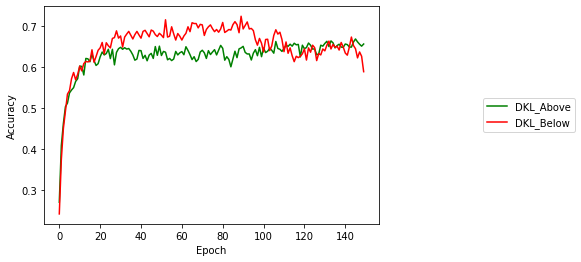

In [16]:
fig1 = plt.figure()


plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_DKL_accuracy_mit_indoor.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


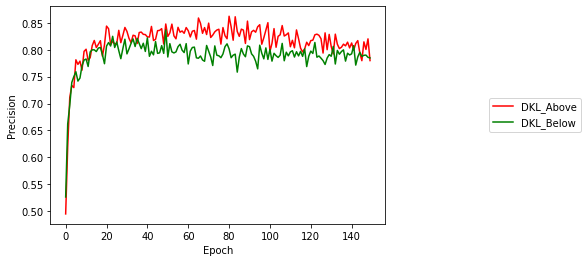

In [19]:
fig1 = plt.figure()

plt.plot(history.history['precision'], color='r')
plt.plot(history2.history['precision'], color='g')

plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_DKL_precision_mit_indoor.eps',  dpi=1000, format="eps", bbox_inches="tight") 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


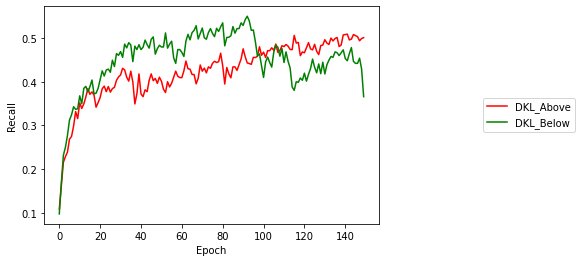

In [21]:
fig1 = plt.figure()
plt.plot(history2.history['recall'], color='r')
plt.plot(history.history['recall'], color='g')

plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('vgg16_lbp_DKL_recall_mit_indoor.eps',  dpi=1000, format="eps", bbox_inches="tight") 
